In [1]:
import numpy as np
from glob import glob
import pandas as pd
import json

import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('ggplot')

In [2]:
def summarize_gradient_table(model='erm', dataset='cifar10', sample_size=5000):
    if model == 'erm':
        batch_factor = 64.
    else:
        batch_factor = 1.
        
    for i in range(5):
        path_list = sorted(glob('../results/{}/{}.{}@{}-1/gradients_*.txt'.format(model, dataset,i+1, sample_size)))
        tmp = []
        for ind, path in enumerate(path_list):
            f = json.load(open(path, "r"))
            df_tmp = pd.DataFrame(f)
            df_tmp.columns=['epoch_{}'.format((ind+1)*10)]
            tmp.append(df_tmp)
        if i == 0:
            df = pd.concat(tmp, axis=1)*batch_factor/5
        else:
            df = df + pd.concat(tmp, axis=1)*batch_factor/5
    return df

# Distribution of gradients vs epochs
## CIFAR10

In [3]:
'''
CIFAR 5000
'''
erm_5k_df = summarize_gradient_table(model='erm', dataset='cifar10', sample_size=5000)
mixup_5k_df = summarize_gradient_table(model='mixup', dataset='cifar10', sample_size=5000)
droid_5k_df = summarize_gradient_table(model='l2_0.008', dataset='cifar10', sample_size=5000)
'''
CIFAR 50000
'''
erm_50k_df = summarize_gradient_table(model='erm', dataset='cifar10', sample_size=50000)
mixup_50k_df = summarize_gradient_table(model='mixup', dataset='cifar10', sample_size=50000)
droid_50k_df = summarize_gradient_table(model='l2_0.008', dataset='cifar10', sample_size=50000)

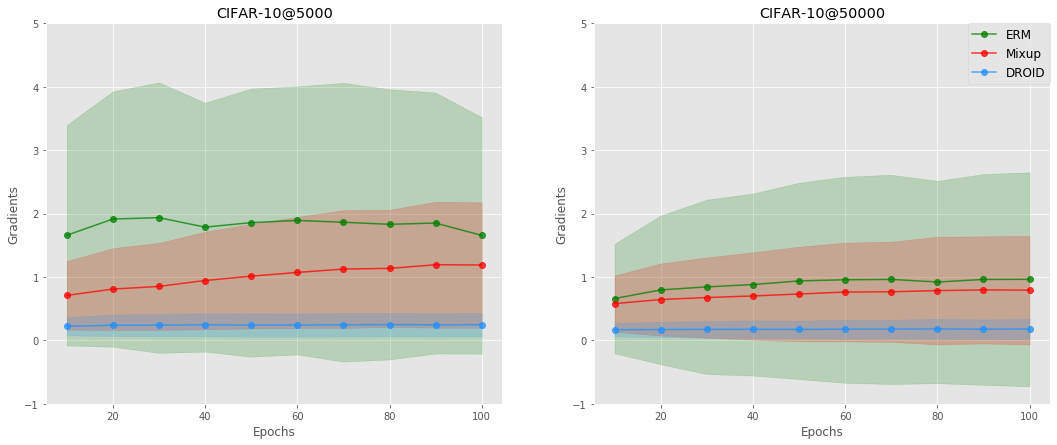

In [4]:
colors=['green','red', 'dodgerblue']
df_list=[erm_5k_df, mixup_5k_df, droid_5k_df]
names=['ERM','Mixup','DROID']

plt.figure(figsize=(18,7))
plt.subplot(121)
for i in range(len(colors)):
    ymean, yerr = df_list[i].mean(), df_list[i].std()
    x_list = np.linspace(10,100, 10)
    plt.plot(x_list, ymean, marker='o', color=colors[i], label=names[i], alpha=0.75) 
    plt.fill_between(x_list, ymean-yerr, ymean+yerr, alpha=0.2, edgecolor=colors[i], facecolor=colors[i])

plt.xlabel('Epochs')
plt.ylabel('Gradients')
plt.ylim(-1, 5)
plt.title('CIFAR-10@5000')

df_list=[erm_50k_df, mixup_50k_df, droid_50k_df]
plt.subplot(122)
for i in range(len(colors)):
    ymean, yerr = df_list[i].mean(), df_list[i].std()
    x_list = np.linspace(10,100, 10)
    plt.plot(x_list, ymean, marker='o', color=colors[i], label=names[i], alpha=0.75) 
    plt.fill_between(x_list, ymean-yerr, ymean+yerr, alpha=0.2, edgecolor=colors[i], facecolor=colors[i])

    
plt.legend(loc='upper right', borderaxespad=0., fontsize=12)
plt.xlabel('Epochs')
plt.ylabel('Gradients')
plt.ylim(-1, 5)
plt.title('CIFAR-10@50000')
plt.savefig('figures/cifar10_grad_vs_epoch.pdf', dpi=300, bbox_inches='tight', pad_inches=0)

## CIFAR100

'''
CIFAR 5000
'''
erm_100_5k_df = summarize_gradient_table(model='erm', dataset='cifar100', sample_size=5000)
mixup_100_5k_df = summarize_gradient_table(model='mixup', dataset='cifar100', sample_size=5000)
droid_100_5k_df = summarize_gradient_table(model='l2_0.008', dataset='cifar100', sample_size=5000)
'''
CIFAR 50000
'''
erm_100_50k_df = summarize_gradient_table(model='erm', dataset='cifar100', sample_size=50000)
mixup_100_50k_df = summarize_gradient_table(model='mixup', dataset='cifar100', sample_size=50000)
droid_100_50k_df = summarize_gradient_table(model='l2_0.008', dataset='cifar100', sample_size=50000)

colors=['green','red', 'dodgerblue']
df_list=[erm_100_5k_df, mixup_100_5k_df, droid_100_5k_df]
names=['ERM','Mixup','DROID']

plt.figure(figsize=(18,7))
plt.subplot(121)
for i in range(len(colors)):
    ymean, yerr = df_list[i].mean(), df_list[i].std()
    x_list = np.linspace(10,100, 10)
    plt.plot(x_list, ymean, marker='o', color=colors[i], label=names[i], alpha=0.75) 
    plt.fill_between(x_list, ymean-yerr, ymean+yerr, alpha=0.2, edgecolor=colors[i], facecolor=colors[i])

plt.xlabel('Epochs')
plt.ylabel('Gradients')
plt.ylim(-1, 5)
plt.title('CIFAR-100@5000')

df_list=[erm_100_50k_df, mixup_100_50k_df, droid_100_50k_df]
plt.subplot(122)
for i in range(len(colors)):
    ymean, yerr = df_list[i].mean(), df_list[i].std()
    x_list = np.linspace(10,100, 10)
    plt.plot(x_list, ymean, marker='o', color=colors[i], label=names[i], alpha=0.75) 
    plt.fill_between(x_list, ymean-yerr, ymean+yerr, alpha=0.2, edgecolor=colors[i], facecolor=colors[i])

    
plt.legend(loc='upper right', borderaxespad=0., fontsize=12)
plt.xlabel('Epochs')
plt.ylabel('Gradients')
plt.ylim(-1, 5)
plt.title('CIFAR-100@50000')
plt.savefig('figures/cifar100_grad_vs_epoch.pdf', dpi=300, bbox_inches='tight', pad_inches=0)

# Density of gradients vs epochs
## CIFAR10

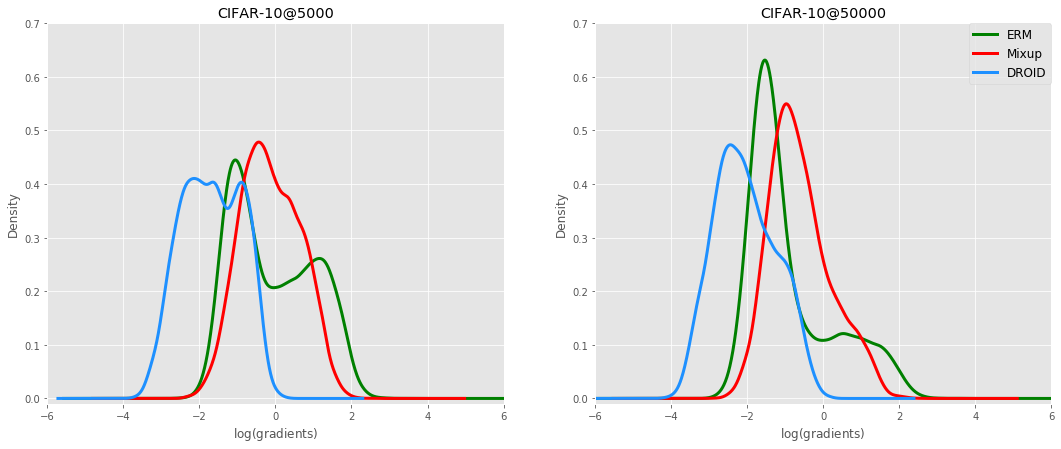

In [5]:
plt.figure(figsize=(18,7))
plt.subplot(121)

np.log(erm_5k_df['epoch_100']).plot.density(c=colors[0], label=names[0], linewidth=3)
np.log(mixup_5k_df['epoch_100']).plot.density(c=colors[1], label=names[1], linewidth=3)
np.log(droid_5k_df['epoch_100']).plot.density(c=colors[2], label=names[2], linewidth=3)
# plt.legend(loc='upper right', borderaxespad=0., fontsize=12)
plt.xlim(-6, 6)
plt.ylim(-0.01, .7)
plt.xlabel('$\log$(gradients)')
plt.ylabel('Density')
plt.title('CIFAR-10@5000')

plt.subplot(122)
np.log(erm_50k_df['epoch_100']).plot.density(c=colors[0], label=names[0], linewidth=3)
np.log(mixup_50k_df['epoch_100']).plot.density(c=colors[1], label=names[1], linewidth=3)
np.log(droid_50k_df['epoch_100']).plot.density(c=colors[2], label=names[2], linewidth=3)
plt.xlim(-6, 6)
plt.ylim(-0.01, .7)
plt.legend(loc='upper right', borderaxespad=0., fontsize=12)
plt.xlabel('$\log$(gradients)')
# plt.ylabel('Density')
plt.title('CIFAR-10@50000')

plt.savefig('figures/cifar10_density.pdf', dpi=300, bbox_inches='tight', pad_inches=0)

## CIFAR100

plt.figure(figsize=(18,7))
plt.subplot(121)

np.log(erm_100_5k_df['epoch_100']).plot.density(c=colors[0], label=names[0], linewidth=3)
np.log(mixup_100_5k_df['epoch_100']).plot.density(c=colors[1], label=names[1], linewidth=3)
np.log(droid_100_5k_df['epoch_100']).plot.density(c=colors[2], label=names[2], linewidth=3)
# plt.legend(loc='upper right', borderaxespad=0., fontsize=12)
plt.xlim(-6, 6)
plt.ylim(-0.01, .7)
plt.xlabel('$\log$(gradients)')
plt.ylabel('Density')
plt.title('CIFAR-100@5000')

plt.subplot(122)
np.log(erm_100_50k_df['epoch_100']).plot.density(c=colors[0], label=names[0], linewidth=3)
np.log(mixup_100_50k_df['epoch_100']).plot.density(c=colors[1], label=names[1], linewidth=3)
np.log(droid_100_50k_df['epoch_100']).plot.density(c=colors[2], label=names[2], linewidth=3)
plt.xlim(-6, 6)
plt.ylim(-0.01, .7)
plt.legend(loc='upper right', borderaxespad=0., fontsize=12)
plt.xlabel('$\log$(gradients)')
# plt.ylabel('Density')
plt.title('CIFAR-100@50000')

plt.savefig('figures/cifar100_density.pdf', dpi=300, bbox_inches='tight', pad_inches=0)